# Подготовка окружения для соревнования

In [ ]:
#!pip install ipython-autotime kaggle --quiet
#%load_ext autotime

time: 0 ns (started: 2024-12-11 18:26:07 +03:00)


DEPRECATION: Loading egg at c:\users\t0pcup\miniconda3\envs\ocr\lib\site-packages\encodechka_eval-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\t0pcup\miniconda3\envs\ocr\lib\site-packages\razdel-0.5.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [1]:
import torch

torch.cuda.is_available()

False

In [3]:
# # Optionally, you can dowload the data right here, if you have Kaggle api token (kaggle.json)

# # Upload your token
# from google.colab import files
# files.upload()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

# ! kaggle competitions download -c are-they-alive
# ! unzip -q /content/are-they-alive.zip

time: 0 ns (started: 2024-12-11 18:26:08 +03:00)


# ВАШЕ РЕШЕНИЕ

---

## Загрузка данных

In [2]:
# train_dataset_dir = "/content/train_dataset"
# test_dataset_dir = "/content/test_dataset"
train_dataset_dir = "are-they-alive/train_dataset"
test_dataset_dir = "are-they-alive/test_dataset"

In [3]:
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Load the train dataset
train_dataset = ImageFolder(root=train_dataset_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Loaded train dataset with {len(train_dataset)} samples")
train_dataset[0]

Loaded train dataset with 5000 samples


(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.5843, 0.4471, 0.3059],
          [0.0000, 0.0000, 0.0000,  ..., 0.6784, 0.5529, 0.4392],
          [0.0000, 0.0000, 0.0000,  ..., 0.6941, 0.5765, 0.4902],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5843, 0.5098, 0.4118],
          [0.0000, 0.0000, 0.0000,  ..., 0.5922, 0.5373, 0.4706],
          [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5647, 0.5255]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.5882, 0.4471, 0.3059],
          [0.0000, 0.0000, 0.0000,  ..., 0.6863, 0.5608, 0.4431],
          [0.0000, 0.0000, 0.0000,  ..., 0.7020, 0.5843, 0.4941],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5216, 0.4235],
          [0.0000, 0.0000, 0.0000,  ..., 0.6078, 0.5529, 0.4824],
          [0.0000, 0.0000, 0.0000,  ..., 0.6157, 0.5804, 0.5373]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.5922, 0.4627, 0.3176],
          [0.0000, 0.0000, 0.0000,  ..., 0.6902, 0.5686, 0.4549],
          [0.0000, 0.0000, 0.0000,  ...,

я встрою аугментации "на лету" в датасет

In [4]:
import numpy as np
import albumentations as A
import torchvision.models as models
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, is_train: bool = False):
        if is_train:
            self.images = list(Path(root_dir + "/0/").glob("*"))
            self.images += list(Path(root_dir + "/1/").glob("*"))
        else:
            self.images = list(Path(root_dir).glob("*"))
        
        self.root_dir = Path(root_dir)


    def __len__(self):
        return len(self.images)

    def get_transforms():
        return

    def augment(self, image):
        transforms = A.Compose(
            [
                # A.Rotate(),
                # A.RandomRotate90(always_apply=True),
                # A.OneOf(
                #     [
                #         A.RandomRain(),
                #         A.RandomFog(),
                #         A.RandomShadow(),
                #         A.RandomSunFlare(),
                #         A.RandomSnow()
                #     ],
                #     p=0.2,
                # ),
                # A.OneOf(
                #     [
                #         A.RandomBrightnessContrast(),
                #         A.RandomGamma(),
                #         A.RandomToneCurve(),
                #     ],
                #     p=0.4,
                # ),
                # A.RandomResizedCrop(image.shape[:2], p=0.2),
                # A.ChannelShuffle(),
                A.Normalize(),
            ]
        )
        return transforms(image=image)["image"]

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = np.array(Image.open(img_path))
        image = self.augment(image).astype(np.double)#.astype(np.float64)

        return np.transpose(image, axes=(2, 0, 1)), img_path.name


# Create a custom dataset from the folder containing the images
test_dataset = CustomImageDataset(root_dir=test_dataset_dir)
full_dataset = CustomImageDataset(root_dir=train_dataset_dir, is_train=True)

# Create a dataloader to load the images in batches
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

print(f"Loaded test dataset with {len(test_dataset)} samples")
# test_dataset[0]

C:\Users\Mike\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded test dataset with 5000 samples


## Инициализация модели

In [5]:
from torch import nn


class MyNet2(nn.Module):
    def __init__(self):
        super(MyNet2, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 1),
        )

        self.sigm = nn.Sequential(nn.Sigmoid())

    def _forward_item(self, x):
        out: torch.Tensor = self.conv_layers(x)
        # print(out.shape)
        out = out.view(-1, 64 * 12 * 12)
        out = self.fc_layers(out)
        return out

    def forward(self, x):
        h, w = list(x.shape)[-2:]
        h_mid, w_mid = h // 2, w // 2
        q1, q2, q3, q4 = (
            x[:, :, 0:h_mid, 0:w_mid],
            x[:, :, h_mid:h, 0:w_mid],
            x[:, :, 0:h_mid, w_mid:w],
            x[:, :, h_mid:h, w_mid:w],
        )
        out = torch.Tensor([])
        for q in [q1, q2, q3, q4]:
            clasified = self._forward_item(q).unsqueeze(0)
            out = torch.cat([out, clasified])

        out: torch.Tensor = self.sigm(out.transpose(1, 0))
        out = out.round().squeeze(-1).sum(dim=-1)
        # print(out)
        out = (out > 0).float()
        out.requires_grad = True
        return out


model0 = MyNet2()

from torch import nn


class ImprovedMyNet(nn.Module):
    def __init__(self):
        super(ImprovedMyNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),  # Assuming input size is 224x224
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

        self.sigm = nn.Sigmoid()

    def _forward_item(self, x):
        out: torch.Tensor = self.conv_layers(x)
        # print(out.shape)
        out = out.view(-1, 32 * 4 * 4)
        out = self.fc_layers(out)
        return out

    def forward(self, x):
        h, w = list(x.shape)[-2:]
        h_mid, w_mid = h // 2, w // 2
        q1, q2, q3, q4 = (
            x[:, :, 0:h_mid, 0:w_mid],
            x[:, :, h_mid:h, 0:w_mid],
            x[:, :, 0:h_mid, w_mid:w],
            x[:, :, h_mid:h, w_mid:w],
        )
        out = torch.Tensor([])
        for q in [q1, q2, q3, q4]:
            clasified = self._forward_item(q).unsqueeze(0)
            out = torch.cat([out, clasified])

        out: torch.Tensor = self.sigm(out.transpose(1, 0))
        out = out.round().squeeze(-1).sum(dim=-1)
        # print(out)
        out = (out > 0).float()
        out.requires_grad = True
        return out


model = ImprovedMyNet()

In [6]:
total_params = sum(p.numel() for p in model.parameters())
scale = total_params / (10**6)

print(f"Total number of parameters in the network: {total_params} (X{scale:.2})")
assert total_params < 10**6

Total number of parameters in the network: 80129 (X0.08)


In [7]:
total_params = sum(p.numel() for p in model0.parameters())
scale = total_params / (10**6)

print(f"Total number of parameters in the network: {total_params} (X{scale:.2})")
assert total_params < 10**6

Total number of parameters in the network: 613761 (X0.61)


## Обучение модели и все остальное

In [9]:
import os
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR

NUM_EPOCH = 15
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.01)

criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MarginRankingLoss(margin=0.2)
# criterion = nn.CosineEmbeddingLoss(margin=0)

sheduler = LambdaLR(optimizer, lr_lambda=lambda epo: 0.8**epo)

train_losses = []
val_losses = []
accuracies = []
best_accuracy = 0
trues = os.listdir(train_dataset_dir + "/1/")
for epo in range(NUM_EPOCH):
    # Функция обучения
    model.train()
    for inputs, names in tqdm(train_loader, desc=f"#{epo} train"):
        optimizer.zero_grad()
        outputs: torch.Tensor = model(torch.Tensor(inputs).float()).squeeze(-1).round()
        labels = torch.Tensor([name in trues for name in names]).float()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    sheduler.step()
    # Функция валидации
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs_val, names in tqdm(valid_loader, desc=f"#{epo} valid"):
            outputs: torch.Tensor = model(torch.Tensor(inputs_val).float()).squeeze(-1)
            labels_val = torch.Tensor([name in trues for name in names]).float()
            loss = criterion(outputs, labels_val)
            val_loss += loss.item()
            correct += (outputs.round() == labels_val).sum().item()

    val_loss /= len(valid_loader)
    accuracy = correct / len(valid_loader.dataset)

    l_t_loss = f"Train Loss: {loss.item():.4f}"
    l_v_loss = f"Val Loss: {val_loss:.4f}"
    l_acc = f"Val Acc: {accuracy:.4f}"
    print(f"Epoch {epo+1}/{NUM_EPOCH}, {l_t_loss}, {l_v_loss}, {l_acc}")

    # Обновление метрик
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    accuracies.append(accuracy)

    # Сохранение лучшей модели
    if accuracy > best_accuracy:
        best_model_wts = model.state_dict()

#0 valid: 100%|██████████| 32/32 [00:02<00:00, 14.51it/s]


Epoch 1/15, Train Loss: 50.0000, Val Loss: 56.2500, Val Acc: 0.4360


#1 valid: 100%|██████████| 32/32 [00:02<00:00, 15.20it/s]


Epoch 2/15, Train Loss: 50.0000, Val Loss: 56.1523, Val Acc: 0.4370


#2 valid: 100%|██████████| 32/32 [00:01<00:00, 16.08it/s]


Epoch 3/15, Train Loss: 62.5000, Val Loss: 56.2500, Val Acc: 0.4390


#3 valid: 100%|██████████| 32/32 [00:01<00:00, 16.23it/s]


Epoch 4/15, Train Loss: 62.5000, Val Loss: 55.9570, Val Acc: 0.4420


#4 valid: 100%|██████████| 32/32 [00:01<00:00, 16.24it/s]


Epoch 5/15, Train Loss: 50.0000, Val Loss: 55.9570, Val Acc: 0.4390


#5 valid: 100%|██████████| 32/32 [00:01<00:00, 16.17it/s]


Epoch 6/15, Train Loss: 37.5000, Val Loss: 55.2734, Val Acc: 0.4430


#6 valid: 100%|██████████| 32/32 [00:01<00:00, 16.25it/s]


Epoch 7/15, Train Loss: 62.5000, Val Loss: 56.0547, Val Acc: 0.4410


#7 valid: 100%|██████████| 32/32 [00:01<00:00, 16.33it/s]


Epoch 8/15, Train Loss: 25.0000, Val Loss: 55.5664, Val Acc: 0.4370


#8 valid: 100%|██████████| 32/32 [00:01<00:00, 16.19it/s]


Epoch 9/15, Train Loss: 62.5000, Val Loss: 56.1523, Val Acc: 0.4400


#9 valid: 100%|██████████| 32/32 [00:02<00:00, 15.90it/s]


Epoch 10/15, Train Loss: 62.5000, Val Loss: 56.3477, Val Acc: 0.4380


#10 valid: 100%|██████████| 32/32 [00:02<00:00, 15.83it/s]


Epoch 11/15, Train Loss: 62.5000, Val Loss: 56.2500, Val Acc: 0.4390


#11 valid: 100%|██████████| 32/32 [00:01<00:00, 16.10it/s]


Epoch 12/15, Train Loss: 87.5000, Val Loss: 56.8359, Val Acc: 0.4390


#12 valid: 100%|██████████| 32/32 [00:02<00:00, 14.76it/s]


Epoch 13/15, Train Loss: 50.0000, Val Loss: 56.0547, Val Acc: 0.4380


#13 valid: 100%|██████████| 32/32 [00:02<00:00, 15.32it/s]


Epoch 14/15, Train Loss: 37.5000, Val Loss: 55.1758, Val Acc: 0.4440


#14 valid: 100%|██████████| 32/32 [00:02<00:00, 15.73it/s]

Epoch 15/15, Train Loss: 75.0000, Val Loss: 56.5430, Val Acc: 0.4390


In [10]:
import os
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR

NUM_EPOCH = 15
optimizer = torch.optim.Adam(model0.parameters(), lr=0.0001)

criterion = nn.BCELoss()

sheduler = LambdaLR(optimizer, lr_lambda=lambda epo: 0.8**epo)

train_losses = []
val_losses = []
accuracies = []
best_accuracy = 0
trues = os.listdir(train_dataset_dir + "/1/")
for epo in range(NUM_EPOCH):
    # Функция обучения
    model0.train()
    for inputs, names in tqdm(train_loader, desc=f"#{epo} train"):
        optimizer.zero_grad()
        outputs: torch.Tensor = model0(torch.Tensor(inputs).float()).squeeze(-1).round()
        labels = torch.Tensor([name in trues for name in names]).float()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    sheduler.step()
    # Функция валидации
    model0.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs_val, names in tqdm(valid_loader, desc=f"#{epo} valid"):
            outputs: torch.Tensor = model0(torch.Tensor(inputs_val).float()).squeeze(-1)
            labels_val = torch.Tensor([name in trues for name in names]).float()
            loss = criterion(outputs, labels_val)
            val_loss += loss.item()
            correct += (outputs.round() == labels_val).sum().item()

    val_loss /= len(valid_loader)
    accuracy = correct / len(valid_loader.dataset)

    l_t_loss = f"Train Loss: {loss.item():.4f}"
    l_v_loss = f"Val Loss: {val_loss:.4f}"
    l_acc = f"Val Acc: {accuracy:.4f}"
    print(f"Epoch {epo+1}/{NUM_EPOCH}, {l_t_loss}, {l_v_loss}, {l_acc}")

    # Обновление метрик
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    accuracies.append(accuracy)

    # Сохранение лучшей модели
    if accuracy > best_accuracy:
        best_model_wts = model0.state_dict()

#0 valid: 100%|██████████| 32/32 [00:03<00:00, 10.09it/s]


Epoch 1/15, Train Loss: 75.0000, Val Loss: 55.2734, Val Acc: 0.4520


#1 valid: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s]


Epoch 2/15, Train Loss: 25.0000, Val Loss: 53.4180, Val Acc: 0.4590


#2 valid: 100%|██████████| 32/32 [00:03<00:00,  9.87it/s]


Epoch 3/15, Train Loss: 12.5000, Val Loss: 52.9297, Val Acc: 0.4610


#3 valid: 100%|██████████| 32/32 [00:03<00:00,  9.72it/s]


Epoch 4/15, Train Loss: 37.5000, Val Loss: 53.4180, Val Acc: 0.4620


#4 valid: 100%|██████████| 32/32 [00:03<00:00,  9.41it/s]


Epoch 5/15, Train Loss: 50.0000, Val Loss: 53.2227, Val Acc: 0.4670


#5 valid: 100%|██████████| 32/32 [00:03<00:00,  9.39it/s]


Epoch 6/15, Train Loss: 62.5000, Val Loss: 54.1016, Val Acc: 0.4610


#6 valid: 100%|██████████| 32/32 [00:03<00:00,  9.33it/s]


Epoch 7/15, Train Loss: 25.0000, Val Loss: 53.3203, Val Acc: 0.4600


#7 valid: 100%|██████████| 32/32 [00:03<00:00,  9.43it/s]


Epoch 8/15, Train Loss: 62.5000, Val Loss: 53.9062, Val Acc: 0.4630


#8 valid: 100%|██████████| 32/32 [00:03<00:00,  9.69it/s]


Epoch 9/15, Train Loss: 50.0000, Val Loss: 53.6133, Val Acc: 0.4630


#9 valid: 100%|██████████| 32/32 [00:03<00:00,  9.68it/s]


Epoch 10/15, Train Loss: 50.0000, Val Loss: 53.3203, Val Acc: 0.4660


#10 valid: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s]


Epoch 11/15, Train Loss: 75.0000, Val Loss: 54.6875, Val Acc: 0.4580


#11 valid: 100%|██████████| 32/32 [00:03<00:00,  9.67it/s]


Epoch 12/15, Train Loss: 75.0000, Val Loss: 54.3945, Val Acc: 0.4610


#12 valid: 100%|██████████| 32/32 [00:03<00:00,  9.40it/s]


Epoch 13/15, Train Loss: 62.5000, Val Loss: 53.3203, Val Acc: 0.4690


#13 valid: 100%|██████████| 32/32 [00:03<00:00,  9.45it/s]


Epoch 14/15, Train Loss: 100.0000, Val Loss: 54.8828, Val Acc: 0.4620


#14 valid: 100%|██████████| 32/32 [00:03<00:00,  9.48it/s]

Epoch 15/15, Train Loss: 50.0000, Val Loss: 54.0039, Val Acc: 0.4590


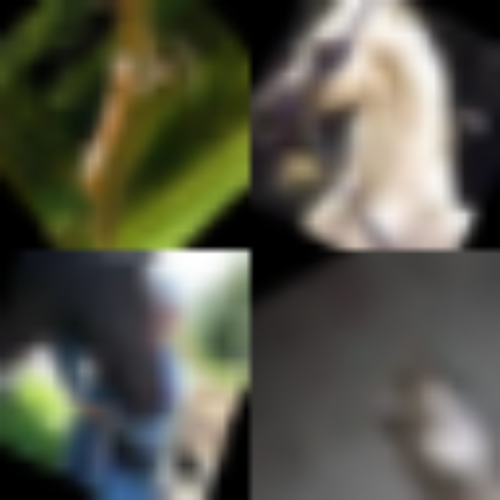

In [11]:
import cv2 as cv

im = np.array(Image.open("are-they-alive/train_dataset/1/image_0.png"))
Image.fromarray(cv.resize(im, (500, 500)))

In [ ]:
# do everything you need to get the best result here

time: 0 ns (started: 2024-12-10 10:24:49 +03:00)


In [ ]:
preds = model(X_test)

In [ ]:
from torchmetrics.classification import BinaryAccuracy

metric = BinaryAccuracy()
accuracy = metric(preds, target)